In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import time, os
from tqdm import tqdm
from sklearn import datasets

In [2]:
import nflib
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow
import nflib.coupling_flows as icf
import nflib.inn_flow as inn
import nflib.res_flow as irf

In [3]:
# np.random.seed(249)
# xx, y = datasets.make_circles(n_samples=300, factor=0.5, noise=0.05)
# x_ = np.random.randn(100, 2)*0.1
# xx = np.concatenate([xx, x_], axis=0)
# y = np.concatenate([y, np.ones(len(x_), dtype=int)*0])

In [4]:
np.random.seed(249) ## 148, 249

xxc, yc = datasets.make_circles(n_samples=265, factor=.5,
                                      noise=.07)
idx = yc==0
xxc = xxc[idx]
yc = yc[idx]

idx = (xxc[:,0]+xxc[:,1]<1)
xxc = xxc[idx]
yc = yc[idx]


xxm, ym = datasets.make_moons(n_samples=200, noise=.15)
xxm = xxm/2 - 0.2

xx = np.concatenate((xxm, xxc), axis=0)
y = np.concatenate((ym, yc+2), axis=0)

In [5]:
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([100, 100, 100]))

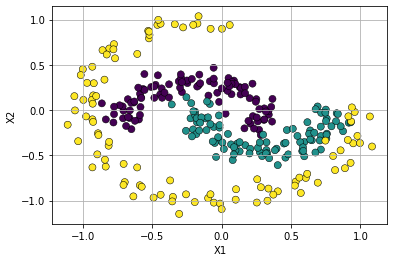

In [6]:
## MinMax Normalization
x1 = xx[:,0]
x2 = xx[:,1]
# x1 = (x1-x1.min())/(x1.max()-x1.min())
# x2 = (x2-x2.min())/(x2.max()-x2.min())
xx = np.column_stack((x1,x2))

xx = torch.Tensor(xx)
yy = torch.Tensor(y.reshape(-1, 1))

%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)

# (x1min, x1max) = -0.1, 1.1
# plt.xlim((x1min, x1max))
# plt.ylim((x1min, x1max))
plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

In [7]:
class ConnectedClassifier_SoftKMeans(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        
#         init_val = torch.ones(num_sets, output_dim)/output_dim

        init_val = torch.randn(num_sets, output_dim)*0.1
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 1.
        self.cls_weight = nn.Parameter(init_val.abs())

        self.cls_confidence = None
        
        
    def forward(self, x, hard=False):
#         self.cls_weight.data.abs_()
#         self.cls_weight.data = self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True)
        
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
        
        if hard:
            x = torch.softmax(-dists*1e5, dim=1)
        else:
            x = torch.softmax(-dists*self.inv_temp, dim=1)
        self.cls_confidence = x
#         c = self.cls_weight
        c = torch.softmax(self.cls_weight, dim=1)
        return x@c

In [8]:
# class LeakySignum(nn.Module):
#     def forward(self, x):
#         x=x+0.5
#         o1x = 0.1*x
#         return torch.minimum(torch.maximum(x, o1x*0.0), o1x+0.9)

In [9]:
class LeakyRectFilter(nn.Module):
    def forward(self, x):
        x = x.abs()
#         return -torch.maximum(torch.minimum(0.1*x-0.15, x-1.5), 0.1*x-1.05)
        return -torch.maximum(torch.minimum(0.01*(x-1.5), x-1.5), 0.1*x-1.05)

## Train, non-softmax based classifier


In [10]:
#### if we use same distance scaler, then same always increasing function, we get same argmax db

In [11]:
class LeakySignum(nn.Module):
    def forward(self, x):
        o1x = 0.1*x
        return torch.minimum(torch.maximum(x, o1x), o1x+0.9)

In [12]:
class DistanceBinaryClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, inv_temp=1):
        super().__init__()
        self.centers = nn.Parameter(torch.rand(1, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1)*-0.5)
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)
        self.actf = nn.Sigmoid()
#         self.actf = LeakySignum()
#         self.actf = LeakyRectFilter()
        self.pos_val = nn.Parameter(torch.ones(1, output_dim)*0.5)
        self.neg_val = nn.Parameter(torch.ones(1, output_dim)*0.5)
        
    def forward(self, x, hard=False):
        self.pos_val.data.abs_()
        self.pos_val.data = self.pos_val.data/self.pos_val.data.sum()
        self.neg_val.data.abs_()
        self.neg_val.data = self.neg_val.data/self.neg_val.data.sum()
        
        x = torch.norm(x-self.centers, dim=1, keepdim=True) + self.bias
        if hard:
            x = torch.sigmoid(-x*1e5)
        else:
            x = self.actf(-x*self.inv_temp)
        x = x*self.pos_val + (1-x)*self.neg_val
        return x

In [13]:
class DistanceMulticlassClassifier(nn.Module):
    
    def __init__(self,input_dim, num_sets, output_dim, inv_temp=1):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_sets = num_sets
        
        self.centers = nn.Parameter(torch.rand(num_sets, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1, num_sets)*-1)
        self.inv_temp = nn.Parameter(torch.ones(1, num_sets)*inv_temp)
        
#         init_val = torch.ones(num_sets, output_dim)/output_dim
        init_val = torch.randn(num_sets, output_dim)*0.1
        for ns in range(num_sets):
            init_val[ns, ns%output_dim] = 1.
        self.cls_weight = nn.Parameter(init_val.abs())

        self.cls_confidence = None
        self.dist_loss = 0
        
#         self.actf = nn.Sigmoid()
        self.actf = LeakySignum()
#         self.actf = LeakyRectFilter()
        
    def forward(self, x, hard=False):
#         self.cls_weight.data.abs_()
#         self.cls_weight.data = self.cls_weight.data/self.cls_weight.data.sum(dim=1, keepdim=True)
        
        x = x[:, :self.input_dim]
        dists = torch.cdist(x, self.centers)
        dists = dists/np.sqrt(self.input_dim) ### correction to make diagonal of unit square 1 in nD space
#         dists = dists*self.inv_temp + self.bias
        dists = dists + self.bias

#         if hard:
        dists = self.actf(-dists)
        indices = torch.argmax(dists, dim=1)
        c = torch.softmax(self.cls_weight, dim=1)

        probs = c[indices]
        scaler = dists[torch.arange(len(indices), dtype=torch.long), indices]
#         print(scaler)
#         print(probs)

        x = torch.softmax(dists, dim=1)
        y = probs*scaler.reshape(-1, 1)
    
        self.cls_confidence = scaler.data
#         self.dist_loss = -torch.cdist(x, self.centers).mean()
#         return x@c
        return y

In [14]:
dmc = DistanceMulticlassClassifier(2, 5, 3)

In [15]:
dmc(torch.randn(10, 2))

tensor([[ 0.3735,  0.1454,  0.1430],
        [ 0.3975,  0.1484,  0.1571],
        [ 0.2926,  0.1139,  0.1120],
        [ 0.1647,  0.4012,  0.1548],
        [ 0.2059,  0.5017,  0.1935],
        [ 0.4605,  0.1720,  0.1820],
        [ 0.2598,  0.1012,  0.0995],
        [-0.0111, -0.0114, -0.0272],
        [ 0.1611,  0.0627,  0.0617],
        [ 0.1587,  0.4194,  0.1719]], grad_fn=<MulBackward0>)

In [16]:
dmc.cls_confidence

tensor([ 0.6619,  0.7030,  0.5186,  0.7207,  0.9012,  0.8145,  0.4604, -0.0497,
         0.2855,  0.7500])

In [17]:
ycls = yy.reshape(-1).type(torch.long)

ycls_ = torch.zeros(len(ycls), ycls.max()+1)
ycls_[torch.arange(0, len(ycls), dtype=torch.long), ycls] = 1.

In [18]:
# ycls_, ycls

In [19]:
# model = nn.Sequential(nn.Linear(2, 10, bias=False),
# #                       nn.BatchNorm1d(10),
#                       nn.SELU(),
#                       nn.Linear(10, 2, bias=False),
# #                       nn.BatchNorm1d(2),
#                       nn.SELU(),
#                      )

In [20]:
actf = irf.Swish
# actf = irf.ReLU
flows = [
    ActNorm(2),
    irf.ResidualFlow(2, [20], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [20], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [20], activation=actf),
    ActNorm(2),
    irf.ResidualFlow(2, [20], activation=actf),
    ActNorm(2),
        ]

model = nn.Sequential(*flows)

In [21]:
# classifier = ConnectedClassifier_SoftKMeans(2, 5, ycls.max().item()+1, inv_temp=1)
# classifier = DistanceBinaryClassifier(2, ycls.max().item()+1, inv_temp=1)
classifier = DistanceMulticlassClassifier(2, 5, ycls.max().item()+1)

In [22]:
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(list(model.parameters())+list(classifier.parameters()), lr=0.001)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  432


In [23]:
%matplotlib tk
fig = plt.figure(figsize=(12, 6))
ax, ax_ = fig.subplots(1, 2)

model.train()
losses = []
NUM = 512

### for plotting in 2d grid
ng = 400
# _a,_b,_c,_d = x1.min()-0.1, x1.max()+0.1, x2.min()-0.1, x2.max()+0.1
s = 1.0
_a,_b,_c,_d = x1.min()-s, x1.max()+s, x2.min()-s, x2.max()+s
xg, yg = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xg, yg = np.meshgrid(xg, yg)
xyg = np.stack([xg.reshape(-1), yg.reshape(-1)], axis=-1)
xyg = torch.Tensor(xyg)

for epoch in tqdm(range(1000*10+1)):
    optimizer.zero_grad()
    
    z = model(xx)
    yout = classifier(z)
    
    loss = criterion(yout, ycls_) #+ classifier.dist_loss*0.001
#     loss = criterion(yout, ycls)
    loss.backward()
    optimizer.step()
        
    if epoch%100 == 0:
        acc = (yout.data.argmax(dim=1) == ycls)
        acc = float(acc.type(torch.float32).mean())
        losses.append(float(loss))
        print(f"Epoch: {epoch} Loss: {losses[-1]} Accuracy: {acc}")

        ax.clear(); ax_.clear()
        with torch.no_grad():
            z = model(xx)
            yout = classifier(z)
            
        yout_img = classifier(model(xyg))
        out = yout_img.data.argmax(dim=1).numpy()
#         out = yout_img.data[torch.arange(0, len(out), dtype=torch.long), out.reshape(-1)].numpy()

        cf = ax.contourf(xg, yg, out.reshape(xg.shape),# v,
                         alpha=0.5, antialiased=True)

        cf = ax_.contourf(xg, yg, classifier.cls_confidence.reshape(xg.shape),
                         alpha=0.5, antialiased=True, levels=15)
        ax.grid()

        ax_.scatter(x1, x2, c=ycls.numpy().reshape(-1), s=40, edgecolors='k', lw=0.5)
        ax.scatter(x1, x2, c=ycls.numpy().reshape(-1), s=40, edgecolors='k', lw=0.5)
#         ax.scatter(x1, x2, c=yout.data.argmax(dim=1).numpy().reshape(-1), marker='.')
            
        fig.canvas.draw()
        plt.savefig("./output/03.3_ood_3moons.png")
        plt.pause(0.01)
plt.close()

  0%|          | 0/10001 [00:00<?, ?it/s]

Epoch: 0 Loss: 0.28680601716041565 Accuracy: 0.2266666740179062


  1%|          | 96/10001 [00:01<01:26, 114.09it/s]

Epoch: 100 Loss: 0.2218344658613205 Accuracy: 0.3766666650772095


  2%|▏         | 198/10001 [00:03<01:29, 109.10it/s]

Epoch: 200 Loss: 0.20477795600891113 Accuracy: 0.43666666746139526


  3%|▎         | 286/10001 [00:04<01:36, 100.90it/s]

Epoch: 300 Loss: 0.18189868330955505 Accuracy: 0.550000011920929


  4%|▍         | 389/10001 [00:05<01:23, 114.87it/s]

Epoch: 400 Loss: 0.17789462208747864 Accuracy: 0.5533333420753479


  5%|▍         | 491/10001 [00:07<01:21, 117.21it/s]

Epoch: 500 Loss: 0.16855813562870026 Accuracy: 0.54666668176651


  6%|▌         | 593/10001 [00:08<01:20, 116.90it/s]

Epoch: 600 Loss: 0.17139020562171936 Accuracy: 0.5766666531562805


  7%|▋         | 693/10001 [00:09<01:23, 111.32it/s]

Epoch: 700 Loss: 0.16319142282009125 Accuracy: 0.6600000262260437


  8%|▊         | 796/10001 [00:11<01:19, 116.29it/s]

Epoch: 800 Loss: 0.15819083154201508 Accuracy: 0.6899999976158142


  9%|▉         | 899/10001 [00:12<01:17, 117.31it/s]

Epoch: 900 Loss: 0.15041415393352509 Accuracy: 0.6966666579246521


 10%|▉         | 996/10001 [00:13<01:22, 108.97it/s]

Epoch: 1000 Loss: 0.13173100352287292 Accuracy: 0.7400000095367432


 11%|█         | 1098/10001 [00:15<01:17, 115.49it/s]

Epoch: 1100 Loss: 0.12087526172399521 Accuracy: 0.7699999809265137


 12%|█▏        | 1186/10001 [00:16<01:20, 109.95it/s]

Epoch: 1200 Loss: 0.10788662731647491 Accuracy: 0.800000011920929


 13%|█▎        | 1289/10001 [00:17<01:15, 114.94it/s]

Epoch: 1300 Loss: 0.10440827906131744 Accuracy: 0.8066666722297668


 14%|█▍        | 1390/10001 [00:19<01:15, 113.33it/s]

Epoch: 1400 Loss: 0.09979761391878128 Accuracy: 0.8166666626930237


 15%|█▍        | 1494/10001 [00:20<01:13, 115.92it/s]

Epoch: 1500 Loss: 0.10055962204933167 Accuracy: 0.8133333325386047


 16%|█▌        | 1587/10001 [00:21<01:22, 101.98it/s]

Epoch: 1600 Loss: 0.10137409716844559 Accuracy: 0.8066666722297668


 17%|█▋        | 1696/10001 [00:23<01:13, 112.79it/s]

Epoch: 1700 Loss: 0.09582650661468506 Accuracy: 0.8166666626930237


 18%|█▊        | 1789/10001 [00:24<01:19, 103.51it/s]

Epoch: 1800 Loss: 0.09134349972009659 Accuracy: 0.8233333230018616


 19%|█▉        | 1893/10001 [00:26<01:14, 108.67it/s]

Epoch: 1900 Loss: 0.08472145348787308 Accuracy: 0.8333333134651184


 20%|█▉        | 1989/10001 [00:27<01:14, 107.21it/s]

Epoch: 2000 Loss: 0.08681874722242355 Accuracy: 0.8266666531562805


 21%|██        | 2099/10001 [00:29<01:09, 113.95it/s]

Epoch: 2100 Loss: 0.08497361093759537 Accuracy: 0.8366666436195374


 22%|██▏       | 2193/10001 [00:30<01:14, 104.98it/s]

Epoch: 2200 Loss: 0.07496244460344315 Accuracy: 0.8533333539962769


 23%|██▎       | 2289/10001 [00:31<01:11, 107.70it/s]

Epoch: 2300 Loss: 0.06996293365955353 Accuracy: 0.8633333444595337


 24%|██▍       | 2397/10001 [00:33<01:08, 111.29it/s]

Epoch: 2400 Loss: 0.07134705781936646 Accuracy: 0.8600000143051147


 25%|██▍       | 2492/10001 [00:34<01:10, 106.92it/s]

Epoch: 2500 Loss: 0.06924618035554886 Accuracy: 0.8633333444595337


 26%|██▌       | 2588/10001 [00:36<01:09, 105.93it/s]

Epoch: 2600 Loss: 0.06528614461421967 Accuracy: 0.8700000047683716


 27%|██▋       | 2697/10001 [00:37<01:04, 112.99it/s]

Epoch: 2700 Loss: 0.06691676378250122 Accuracy: 0.8733333349227905


 28%|██▊       | 2788/10001 [00:39<01:11, 101.21it/s]

Epoch: 2800 Loss: 0.06989090144634247 Accuracy: 0.8666666746139526


 29%|██▉       | 2897/10001 [00:40<01:03, 112.29it/s]

Epoch: 2900 Loss: 0.06530372053384781 Accuracy: 0.8733333349227905


 30%|██▉       | 2989/10001 [00:41<01:07, 104.61it/s]

Epoch: 3000 Loss: 0.05941280722618103 Accuracy: 0.8833333253860474


 31%|███       | 3100/10001 [00:43<01:00, 113.73it/s]

Epoch: 3100 Loss: 0.05717024952173233 Accuracy: 0.8866666555404663


 32%|███▏      | 3196/10001 [00:44<01:03, 107.72it/s]

Epoch: 3200 Loss: 0.05306857079267502 Accuracy: 0.8933333158493042


 33%|███▎      | 3292/10001 [00:46<01:02, 107.28it/s]

Epoch: 3300 Loss: 0.05257121101021767 Accuracy: 0.8933333158493042


 34%|███▍      | 3399/10001 [00:47<01:00, 109.96it/s]

Epoch: 3400 Loss: 0.046501751989126205 Accuracy: 0.903333306312561


 35%|███▍      | 3495/10001 [00:49<01:12, 89.85it/s] 

Epoch: 3500 Loss: 0.04991619661450386 Accuracy: 0.8966666460037231


 36%|███▌      | 3588/10001 [00:50<01:00, 105.23it/s]

Epoch: 3600 Loss: 0.04406227916479111 Accuracy: 0.9066666960716248


 37%|███▋      | 3694/10001 [00:52<00:56, 111.35it/s]

Epoch: 3700 Loss: 0.0454380176961422 Accuracy: 0.903333306312561


 38%|███▊      | 3800/10001 [00:53<00:55, 111.65it/s]

Epoch: 3800 Loss: 0.03942578285932541 Accuracy: 0.9133333563804626


 39%|███▉      | 3893/10001 [00:54<00:57, 105.68it/s]

Epoch: 3900 Loss: 0.04088898375630379 Accuracy: 0.9100000262260437


 40%|███▉      | 3988/10001 [00:56<00:58, 103.24it/s]

Epoch: 4000 Loss: 0.03686708211898804 Accuracy: 0.9166666865348816


 41%|████      | 4096/10001 [00:57<00:52, 112.69it/s]

Epoch: 4100 Loss: 0.03483985736966133 Accuracy: 0.9200000166893005


 42%|████▏     | 4192/10001 [00:59<00:54, 107.54it/s]

Epoch: 4200 Loss: 0.03483318164944649 Accuracy: 0.9200000166893005


 43%|████▎     | 4288/10001 [01:00<00:53, 106.96it/s]

Epoch: 4300 Loss: 0.03674321621656418 Accuracy: 0.9166666865348816


 44%|████▍     | 4396/10001 [01:02<00:50, 111.63it/s]

Epoch: 4400 Loss: 0.03661813214421272 Accuracy: 0.9166666865348816


 45%|████▍     | 4490/10001 [01:03<00:51, 106.48it/s]

Epoch: 4500 Loss: 0.03838377818465233 Accuracy: 0.9133333563804626


 46%|████▌     | 4597/10001 [01:04<00:49, 109.66it/s]

Epoch: 4600 Loss: 0.04009132832288742 Accuracy: 0.9100000262260437


 47%|████▋     | 4692/10001 [01:06<00:49, 107.01it/s]

Epoch: 4700 Loss: 0.03601153939962387 Accuracy: 0.9166666865348816


 48%|████▊     | 4788/10001 [01:07<00:48, 107.10it/s]

Epoch: 4800 Loss: 0.03634348139166832 Accuracy: 0.9166666865348816


 49%|████▉     | 4898/10001 [01:09<00:44, 114.42it/s]

Epoch: 4900 Loss: 0.035808805376291275 Accuracy: 0.9166666865348816


 50%|████▉     | 4992/10001 [01:10<00:47, 104.39it/s]

Epoch: 5000 Loss: 0.0362030491232872 Accuracy: 0.9166666865348816


 51%|█████     | 5087/10001 [01:12<00:45, 106.91it/s]

Epoch: 5100 Loss: 0.037863001227378845 Accuracy: 0.9133333563804626


 52%|█████▏    | 5197/10001 [01:13<00:42, 113.27it/s]

Epoch: 5200 Loss: 0.03573198243975639 Accuracy: 0.9166666865348816


 53%|█████▎    | 5293/10001 [01:14<00:43, 107.16it/s]

Epoch: 5300 Loss: 0.02592022344470024 Accuracy: 0.9333333373069763


 54%|█████▍    | 5389/10001 [01:16<00:42, 107.86it/s]

Epoch: 5400 Loss: 0.029657134786248207 Accuracy: 0.9266666769981384


 55%|█████▍    | 5499/10001 [01:17<00:39, 113.82it/s]

Epoch: 5500 Loss: 0.03171931207180023 Accuracy: 0.9233333468437195


 56%|█████▌    | 5595/10001 [01:19<00:40, 107.90it/s]

Epoch: 5600 Loss: 0.027782129123806953 Accuracy: 0.9300000071525574


 57%|█████▋    | 5690/10001 [01:20<00:40, 105.44it/s]

Epoch: 5700 Loss: 0.035947348922491074 Accuracy: 0.9166666865348816


 58%|█████▊    | 5799/10001 [01:22<00:36, 113.66it/s]

Epoch: 5800 Loss: 0.03154697269201279 Accuracy: 0.9233333468437195


 59%|█████▉    | 5891/10001 [01:23<00:39, 104.10it/s]

Epoch: 5900 Loss: 0.03573014214634895 Accuracy: 0.9166666865348816


 60%|█████▉    | 5999/10001 [01:24<00:35, 112.13it/s]

Epoch: 6000 Loss: 0.031484052538871765 Accuracy: 0.9233333468437195


 61%|██████    | 6094/10001 [01:26<00:37, 104.75it/s]

Epoch: 6100 Loss: 0.029516542330384254 Accuracy: 0.9266666769981384


 62%|██████▏   | 6190/10001 [01:27<00:35, 107.19it/s]

Epoch: 6200 Loss: 0.041645608842372894 Accuracy: 0.9066666960716248


 63%|██████▎   | 6292/10001 [01:29<00:35, 105.46it/s]

Epoch: 6300 Loss: 0.03143426775932312 Accuracy: 0.9233333468437195


 64%|██████▍   | 6389/10001 [01:30<00:37, 96.67it/s] 

Epoch: 6400 Loss: 0.0313798189163208 Accuracy: 0.9233333468437195


 65%|██████▍   | 6494/10001 [01:32<00:32, 108.56it/s]

Epoch: 6500 Loss: 0.037314895540475845 Accuracy: 0.9133333563804626


 66%|██████▌   | 6588/10001 [01:33<00:33, 101.98it/s]

Epoch: 6600 Loss: 0.02918712981045246 Accuracy: 0.9266666769981384


 67%|██████▋   | 6695/10001 [01:35<00:29, 112.00it/s]

Epoch: 6700 Loss: 0.029204918071627617 Accuracy: 0.9266666769981384


 68%|██████▊   | 6790/10001 [01:36<00:30, 103.83it/s]

Epoch: 6800 Loss: 0.0292962733656168 Accuracy: 0.9266666769981384


 69%|██████▉   | 6898/10001 [01:38<00:27, 111.28it/s]

Epoch: 6900 Loss: 0.03551961109042168 Accuracy: 0.9166666865348816


 70%|██████▉   | 6993/10001 [01:39<00:28, 104.17it/s]

Epoch: 7000 Loss: 0.025034595280885696 Accuracy: 0.9700000286102295


 71%|███████   | 7097/10001 [01:41<00:26, 107.62it/s]

Epoch: 7100 Loss: 0.02708936482667923 Accuracy: 0.9666666388511658


 72%|███████▏  | 7188/10001 [01:42<00:27, 100.87it/s]

Epoch: 7200 Loss: 0.031217437237501144 Accuracy: 0.9566666483879089


 73%|███████▎  | 7295/10001 [01:43<00:24, 109.83it/s]

Epoch: 7300 Loss: 0.029067736119031906 Accuracy: 0.9633333086967468


 74%|███████▍  | 7388/10001 [01:45<00:24, 104.88it/s]

Epoch: 7400 Loss: 0.031152235344052315 Accuracy: 0.9566666483879089


 75%|███████▍  | 7493/10001 [01:46<00:23, 106.73it/s]

Epoch: 7500 Loss: 0.033236030489206314 Accuracy: 0.95333331823349


 76%|███████▌  | 7589/10001 [01:48<00:22, 106.71it/s]

Epoch: 7600 Loss: 0.02894575335085392 Accuracy: 0.9666666388511658


 77%|███████▋  | 7696/10001 [01:49<00:20, 110.12it/s]

Epoch: 7700 Loss: 0.024812329560518265 Accuracy: 0.9700000286102295


 78%|███████▊  | 7791/10001 [01:51<00:20, 107.21it/s]

Epoch: 7800 Loss: 0.024726668372750282 Accuracy: 0.9666666388511658


 79%|███████▉  | 7898/10001 [01:52<00:19, 110.46it/s]

Epoch: 7900 Loss: 0.02692660503089428 Accuracy: 0.9666666388511658


 80%|███████▉  | 7993/10001 [01:54<00:19, 105.41it/s]

Epoch: 8000 Loss: 0.03104204311966896 Accuracy: 0.9599999785423279


 81%|████████  | 8087/10001 [01:55<00:18, 105.00it/s]

Epoch: 8100 Loss: 0.030952589586377144 Accuracy: 0.9599999785423279


 82%|████████▏ | 8194/10001 [01:57<00:16, 110.71it/s]

Epoch: 8200 Loss: 0.0307620856910944 Accuracy: 0.9566666483879089


 83%|████████▎ | 8289/10001 [01:58<00:16, 106.12it/s]

Epoch: 8300 Loss: 0.0247285608202219 Accuracy: 0.9700000286102295


 84%|████████▍ | 8399/10001 [01:59<00:14, 112.59it/s]

Epoch: 8400 Loss: 0.02465549297630787 Accuracy: 0.9700000286102295


 85%|████████▍ | 8494/10001 [02:01<00:14, 106.73it/s]

Epoch: 8500 Loss: 0.02456086501479149 Accuracy: 0.9666666388511658


 86%|████████▌ | 8589/10001 [02:02<00:13, 106.78it/s]

Epoch: 8600 Loss: 0.030917726457118988 Accuracy: 0.9566666483879089


 87%|████████▋ | 8699/10001 [02:04<00:11, 113.70it/s]

Epoch: 8700 Loss: 0.026682501658797264 Accuracy: 0.9633333086967468


 88%|████████▊ | 8797/10001 [02:05<00:11, 107.54it/s]

Epoch: 8800 Loss: 0.02670237608253956 Accuracy: 0.9633333086967468


 89%|████████▉ | 8893/10001 [02:06<00:10, 107.31it/s]

Epoch: 8900 Loss: 0.028798706829547882 Accuracy: 0.9599999785423279


 90%|████████▉ | 8988/10001 [02:08<00:09, 104.95it/s]

Epoch: 9000 Loss: 0.024504365399479866 Accuracy: 0.9666666388511658


 91%|█████████ | 9093/10001 [02:09<00:08, 104.79it/s]

Epoch: 9100 Loss: 0.030829906463623047 Accuracy: 0.9566666483879089


 92%|█████████▏| 9188/10001 [02:11<00:08, 98.96it/s] 

Epoch: 9200 Loss: 0.024497410282492638 Accuracy: 0.9666666388511658


 93%|█████████▎| 9294/10001 [02:12<00:06, 106.69it/s]

Epoch: 9300 Loss: 0.026604361832141876 Accuracy: 0.9633333086967468


 94%|█████████▍| 9398/10001 [02:14<00:05, 109.04it/s]

Epoch: 9400 Loss: 0.02457226626574993 Accuracy: 0.9700000286102295


 95%|█████████▍| 9492/10001 [02:15<00:04, 103.39it/s]

Epoch: 9500 Loss: 0.028653673827648163 Accuracy: 0.9633333086967468


 96%|█████████▌| 9594/10001 [02:17<00:03, 107.89it/s]

Epoch: 9600 Loss: 0.02654225006699562 Accuracy: 0.9633333086967468


 97%|█████████▋| 9687/10001 [02:18<00:03, 102.87it/s]

Epoch: 9700 Loss: 0.024355709552764893 Accuracy: 0.9700000286102295


 98%|█████████▊| 9797/10001 [02:20<00:01, 113.30it/s]

Epoch: 9800 Loss: 0.024424871429800987 Accuracy: 0.9700000286102295


 99%|█████████▉| 9891/10001 [02:21<00:01, 104.80it/s]

Epoch: 9900 Loss: 0.03294609859585762 Accuracy: 0.9599999785423279


100%|█████████▉| 9998/10001 [02:23<00:00, 100.30it/s]

Epoch: 10000 Loss: 0.0244513601064682 Accuracy: 0.9666666388511658


100%|██████████| 10001/10001 [02:24<00:00, 69.31it/s]


In [24]:
yout

tensor([[ 1.2458e-02,  8.0995e-01,  4.0695e-03],
        [ 1.5409e-02,  1.0018e+00,  5.0335e-03],
        [ 9.8502e-01,  1.4885e-02,  8.0831e-03],
        [ 1.9840e-02,  9.4003e-01,  1.3404e-02],
        [ 1.0221e+00,  1.5445e-02,  8.3873e-03],
        [ 9.8701e-01,  1.4915e-02,  8.0994e-03],
        [ 9.9476e-01,  1.5032e-02,  8.1631e-03],
        [ 1.0087e+00,  1.5243e-02,  8.2773e-03],
        [ 9.9599e-01,  1.5051e-02,  8.1732e-03],
        [ 1.0073e+00,  1.5221e-02,  8.2657e-03],
        [ 9.9016e-01,  1.4963e-02,  8.1253e-03],
        [ 1.5304e-02,  9.9502e-01,  4.9993e-03],
        [ 1.0089e+00,  1.5247e-02,  8.2794e-03],
        [ 2.2097e-02,  1.0470e+00,  1.4929e-02],
        [ 1.0286e+00,  1.5544e-02,  8.4409e-03],
        [ 1.5203e-02,  9.8841e-01,  4.9661e-03],
        [ 9.8007e-01,  1.4810e-02,  8.0425e-03],
        [ 1.0157e+00,  1.5348e-02,  8.3346e-03],
        [ 9.6806e-01,  1.4629e-02,  7.9440e-03],
        [ 2.0351e-02,  9.6427e-01,  1.3750e-02],
        [ 2.1371e-02

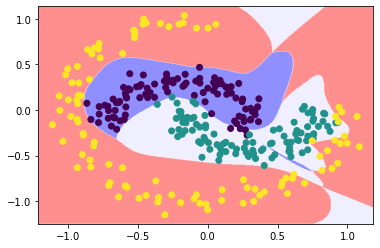

In [25]:
model.eval()
%matplotlib inline

### for plotting in 2d grid
ng = 400
_a,_b,_c,_d = x1.min()-0.1, x1.max()+0.1, x2.min()-0.1, x2.max()+0.1
xg, yg = np.linspace(_a, _b, ng), np.linspace(_c, _d, ng)
xg, yg = np.meshgrid(xg, yg)
xyg = np.stack([xg.reshape(-1), yg.reshape(-1)], axis=-1)
xyg = torch.Tensor(xyg)

with torch.no_grad():
    z = model(xyg)
    y = torch.argmax(classifier(z, hard=True), dim=1)
    
cf = plt.contourf(xg, yg, y.reshape(xg.shape),# v,
                     alpha=0.5, cmap=matplotlib.cm.bwr, antialiased=True)
plt.scatter(x1, x2, marker='o', c=yy.reshape(-1))

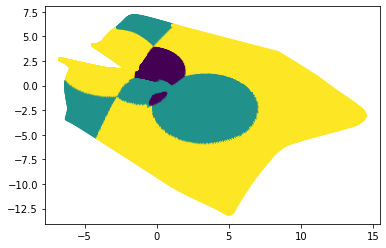

In [26]:
plt.scatter(z[:,0], z[:,1], marker='.', c=y.reshape(-1))   